In [1]:
import numpy as np
from random import random, randint
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
class RasterImage():
    black_color = (   0,   0,   0 )
    white_color = ( 255, 255, 255 )
        
    def __init__(self, width, height, pen=None, bg=None):
        self.width = width
        self.height = height
        
        if pen is None:
            pen = self.black_color
        self.pen = pen
        
        if bg is None:
            bg = self.white_color
        self.bg = bg
        
        self.image = np.zeros((height, width, 3), np.uint8)
        
        self.clear()

    def fill(self, rgb):
        self.image[:, :] = rgb
        
    def clear(self):
        self.fill(self.bg)        

    def swap_pen_bg(self):
        self.pen, self.bg = self.bg, self.pen
    
    def write(self, filename):
         cv.imwrite(filename, self.image)
        
    def show(self):
        plt.imshow(self.image)
    
    def set_bg(self, bg):
        self.bg = bg
    
    def set_pen(self, pen):
        self.pen = pen    

    def pick(self, x, y):
        return self.image[x, y]
        
    def plot(self, x, y, pen=None, erase=False):
        if pen is None:
            pen = self.pen
        if erase:
            pen = self.bg

        self.image[y, x] = pen

    def line(self, x1, y1, x2, y2, pen=None):

        # this is basically Bresenheim's algorithm without the integer arithmetic optimization
        
        def _sign(d):
            if d < 0:
                return -1
            elif d == 0:
                return 0
            else:
                return 1
    
        dx = x2 - x1
        dy = y2 - y1
        
        # always plot the starting point

        self.plot(x1, y1, pen)
        
        if dx != 0 or dy != 0:
            if abs(dx) > abs(dy):
                # plot "horizontal" line

                assert(dx != 0)
                slope = dy / abs(dx)
                dx = _sign(dx)
                x = x1 + dx
                y = float(y1) + slope

                while x != x2:
                    self.plot(x, int(y), pen)
                    x += dx
                    y += slope
            else:
                # plot "vertical" line
                
                assert(dy != 0)
                slope = dx / abs(dy)
                dy = _sign(dy)
                y = y1 + dy
                x = float(x1) + slope

                while y != y2:
                    self.plot(int(x), y, pen)
                    y += dy
                    x += slope
                
            # always plot end point, unless both dx,dy is 0
        
            self.plot(x2, y2, pen)
        else:
            pass # dx & dy = 0
    
    def box(self, x1, y1, x2, y2, pen=None):
        # draw box as horizontal lines
        
        dy = 1
        if y2 < y1:
            dy = -1
       
        y = y1
        while y != y2:
            self.line(x1, y, x2, y, pen)
            y += dy

        # always draw last line
            
        self.line(x1, y2, x2, y2, pen)

In [3]:
def color_generator(r_f, r_phi, g_f, g_phi, b_f, b_phi, doubling_time):
    def channel_oscillator(t):
        p = t % 1
        y = int(511 * p)
        
        if p < 0.5:
            return y
        else:
            return int(510 - y)
    
    rt = r_phi
    gt = g_phi
    bt = b_phi

    fm = 2 ** (1 / doubling_time)

    while(True):
        r = channel_oscillator(rt)
        g = channel_oscillator(gt)
        b = channel_oscillator(bt)

        rt = (rt + r_f) % 1
        gt = (gt + g_f) % 1
        bt = (bt + b_f) % 1

        r_f *= fm
        g_f *= fm
        b_f *= fm
        
        yield (r, g, b)

In [4]:
from itertools import islice
from math import sin, pi

twopi = 2 * pi

class RandomWalks():
    def __init__(self, rasterimage, cg_params):
        self.rasterimage = rasterimage
        self.width = rasterimage.width
        self.height = rasterimage.height
        self.cg_params = cg_params

    def walk(self, steps):
        rasterimage = self.rasterimage
        width = self.width
        height = self.height

        uplr = [ ( 0, -1 ), ( 0, 1 ), ( -1, 0), ( 1, 0 ) ]

        x = width // 2
        y = height // 2
        
        cg = color_generator(*self.cg_params)
        for rgb in islice(cg, steps):
            rasterimage.plot(x, y, pen=rgb)
            d = randint(0, 3)
            dx, dy = uplr[d]

            x = (x + dx) % width
            y = (y + dy) % height     

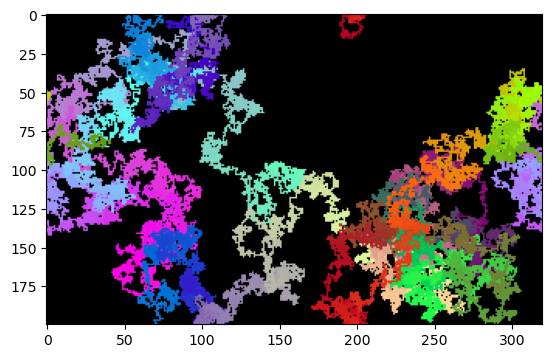

In [6]:
S = 100000 # number of random walk steps

# parameters for color generation

cg_params = ( 1.81 / S, 0.20, 2.91 / S, 0.50, .47 / S, 2.37, S )

width, height = 320, 200

C_BLACK =  (   0,  0,    0 )
C_WHITE =  ( 255, 255, 255 )
C_RED   =  ( 255,   0,   0 )
C_GREEN =  (   0, 255,   0 )
C_BLUE  =  (   0,   0, 255 )

ri = RasterImage(width, height, bg=C_BLACK)
rw = RandomWalks(ri, cg_params)

rw.walk(S)
ri.show()